In [1]:
#reduce lr, try org model dims, check paper

In [2]:
pip install vit-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 4.7 MB/s 


In [3]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import glob
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from __future__ import print_function
from itertools import chain
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from vit_pytorch.max_vit import MaxViT

In [6]:
# Training settings
batch_size = 16
epochs = 200
lr = 0.00001
gamma = 0.7
seed = 42

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [8]:
'''
IMAGE CATEGORY ENCODING

Benign = 0
Malignant = 1
'''

'\nIMAGE CATEGORY ENCODING\n\nBenign = 0\nMalignant = 1\n'

In [9]:
from google.colab import drive
drive.mount('/content/drive')

train_list = glob.glob(os.path.join('/content/drive/MyDrive/BreakHis/benign/SOB/adenosis','*.png'))
train_list2 = glob.glob(os.path.join('/content/drive/MyDrive/BreakHis/benign/SOB/fibroadenoma','*.png'))
train_list.extend(train_list2)
train_list2 = glob.glob(os.path.join('/content/drive/MyDrive/BreakHis/benign/SOB/phyllodes_tumor','*.png'))
train_list.extend(train_list2)
train_list2 = glob.glob(os.path.join('/content/drive/MyDrive/BreakHis/benign/SOB/tubular_adenoma','*.png'))
train_list.extend(train_list2)
train_list2 = glob.glob(os.path.join('/content/drive/MyDrive/BreakHis/malignant/SOB/ductal_carcinoma','*.png'))
train_list.extend(train_list2)
train_list2 = glob.glob(os.path.join('/content/drive/MyDrive/BreakHis/malignant/SOB/lobular_carcinoma','*.png'))
train_list.extend(train_list2)
train_list2 = glob.glob(os.path.join('/content/drive/MyDrive/BreakHis/malignant/SOB/mucinous_carcinoma','*.png'))
train_list.extend(train_list2)
train_list2 = glob.glob(os.path.join('/content/drive/MyDrive/BreakHis/malignant/SOB/papillary_carcinoma','*.png'))
train_list.extend(train_list2)

print(f"Train list length: {len(train_list)}")

Mounted at /content/drive
Train list length: 7909


In [10]:
random.shuffle(train_list)

In [11]:
train_list, test_list = train_test_split(train_list,
                                          test_size=0.15,
                                          random_state=42)

In [12]:
test_list, valid_list = train_test_split(test_list,
                                          test_size=0.33,
                                          random_state=42)

In [13]:
print(f"Train Data: {len(train_list)}")
print(f"Valid Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 6722
Valid Data: 392
Test Data: 795


In [14]:
device = 'cuda'

In [15]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(0, 180)),
        transforms.ColorJitter(brightness=.5, hue=.3),
        transforms.ToTensor(),
    ]
)

valid_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [16]:
class BreakHisDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-4].split(".")[0]
        label = 1 if label == "malignant" else 0

        return img_transformed, label

In [17]:
train_data = BreakHisDataset(train_list, transform=train_transforms)
valid_data = BreakHisDataset(valid_list, transform=valid_transforms)
test_data = BreakHisDataset(test_list, transform=test_transforms)

In [18]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [19]:
model = MaxViT(
    num_classes = 2,
    dim_conv_stem = 64,               # dimension of the convolutional stem, would default to dimension of first layer if not specified
    dim = 96,                         # dimension of first layer, doubles every layer
    dim_head = 32,                    # dimension of attention heads, kept at 32 in paper
    depth = (2, 2, 5, 2),             # number of MaxViT blocks per stage, which consists of MBConv, block-like attention, grid-like attention
    window_size = 7,                  # window size for block and grids
    mbconv_expansion_rate = 4,        # expansion rate of MBConv
    mbconv_shrinkage_rate = 0.25,     # shrinkage rate of squeeze-excitation in MBConv
    dropout = 0.1                     # dropout
).to(device)

In [20]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [21]:
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

bestloss = 100
patience = 15
triggers = 0
batchmul = 4

In [22]:
start_time = time.time()

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    model.train()
    for idx, (data, label) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)/batchmul
        loss.backward()

        if ((idx + 1) % batchmul == 0) or (idx + 1 == len(train_loader)):
          optimizer.step()
          optimizer.zero_grad()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += (loss.item())*batchmul / len(train_loader)

    model.eval()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss.item() / len(valid_loader)
    
    train_loss_list.append(epoch_loss)
    train_accuracy_list.append(epoch_accuracy)
    val_loss_list.append(epoch_val_loss)
    val_accuracy_list.append(epoch_val_accuracy)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    if(epoch_loss < bestloss):
        triggers = 0
        bestloss = epoch_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/SavedViTModels/MaxViTSavedModel2.pth")
        torch.save(optimizer.state_dict(), "/content/drive/MyDrive/SavedViTModels/MaxViTSavedOptimizer2.pth")
    else:
        triggers += 1

    if triggers == patience:
        print("Early stopping since epoch_loss > bestloss for 15 epochs")
        break

end_time = time.time()

print(f"\nTime taken to train the model: {(end_time - start_time)/60/60} hours")

100%|██████████| 421/421 [45:55<00:00,  6.55s/it]


Epoch : 1 - loss : 0.5560 - acc: 0.7271 - val_loss : 0.4719 - val_acc: 0.7950



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 2 - loss : 0.5269 - acc: 0.7466 - val_loss : 0.4706 - val_acc: 0.8200



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 3 - loss : 0.5100 - acc: 0.7577 - val_loss : 0.4482 - val_acc: 0.8325



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 4 - loss : 0.5029 - acc: 0.7690 - val_loss : 0.4288 - val_acc: 0.8425



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 5 - loss : 0.5069 - acc: 0.7640 - val_loss : 0.4710 - val_acc: 0.8100



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 6 - loss : 0.5004 - acc: 0.7703 - val_loss : 0.4180 - val_acc: 0.8525



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 7 - loss : 0.4903 - acc: 0.7791 - val_loss : 0.4574 - val_acc: 0.8025



100%|██████████| 421/421 [05:34<00:00,  1.26it/s]


Epoch : 8 - loss : 0.4942 - acc: 0.7684 - val_loss : 0.4204 - val_acc: 0.8275



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 9 - loss : 0.4907 - acc: 0.7746 - val_loss : 0.4302 - val_acc: 0.8475



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 10 - loss : 0.4839 - acc: 0.7822 - val_loss : 0.4027 - val_acc: 0.8475



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 11 - loss : 0.4823 - acc: 0.7798 - val_loss : 0.4232 - val_acc: 0.8225



100%|██████████| 421/421 [05:34<00:00,  1.26it/s]


Epoch : 12 - loss : 0.4809 - acc: 0.7825 - val_loss : 0.4075 - val_acc: 0.8400



100%|██████████| 421/421 [05:34<00:00,  1.26it/s]


Epoch : 13 - loss : 0.4735 - acc: 0.7864 - val_loss : 0.4082 - val_acc: 0.8275



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 14 - loss : 0.4825 - acc: 0.7776 - val_loss : 0.3973 - val_acc: 0.8425



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 15 - loss : 0.4762 - acc: 0.7810 - val_loss : 0.4106 - val_acc: 0.8375



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 16 - loss : 0.4726 - acc: 0.7890 - val_loss : 0.4078 - val_acc: 0.8400



100%|██████████| 421/421 [05:32<00:00,  1.26it/s]


Epoch : 17 - loss : 0.4631 - acc: 0.7954 - val_loss : 0.3893 - val_acc: 0.8425



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 18 - loss : 0.4742 - acc: 0.7919 - val_loss : 0.4176 - val_acc: 0.8250



100%|██████████| 421/421 [05:32<00:00,  1.26it/s]


Epoch : 19 - loss : 0.4628 - acc: 0.7985 - val_loss : 0.3868 - val_acc: 0.8425



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 20 - loss : 0.4683 - acc: 0.7887 - val_loss : 0.3831 - val_acc: 0.8525



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 21 - loss : 0.4678 - acc: 0.7882 - val_loss : 0.3623 - val_acc: 0.8575



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 22 - loss : 0.4675 - acc: 0.7916 - val_loss : 0.3912 - val_acc: 0.8250



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 23 - loss : 0.4576 - acc: 0.8033 - val_loss : 0.3650 - val_acc: 0.8525



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 24 - loss : 0.4606 - acc: 0.7988 - val_loss : 0.3912 - val_acc: 0.8425



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 25 - loss : 0.4618 - acc: 0.7975 - val_loss : 0.3826 - val_acc: 0.8475



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 26 - loss : 0.4525 - acc: 0.8031 - val_loss : 0.3832 - val_acc: 0.8250



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 27 - loss : 0.4520 - acc: 0.8024 - val_loss : 0.3775 - val_acc: 0.8400



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 28 - loss : 0.4560 - acc: 0.7996 - val_loss : 0.4562 - val_acc: 0.8275



100%|██████████| 421/421 [05:32<00:00,  1.26it/s]


Epoch : 29 - loss : 0.4537 - acc: 0.8060 - val_loss : 0.3629 - val_acc: 0.8675



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 30 - loss : 0.4541 - acc: 0.7999 - val_loss : 0.3591 - val_acc: 0.8625



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 31 - loss : 0.4507 - acc: 0.8080 - val_loss : 0.3701 - val_acc: 0.8475



100%|██████████| 421/421 [05:34<00:00,  1.26it/s]


Epoch : 32 - loss : 0.4499 - acc: 0.8057 - val_loss : 0.3890 - val_acc: 0.8250



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 33 - loss : 0.4368 - acc: 0.8104 - val_loss : 0.3473 - val_acc: 0.8525



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 34 - loss : 0.4388 - acc: 0.8104 - val_loss : 0.3501 - val_acc: 0.8575



100%|██████████| 421/421 [05:32<00:00,  1.26it/s]


Epoch : 35 - loss : 0.4408 - acc: 0.8119 - val_loss : 0.3546 - val_acc: 0.8500



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 36 - loss : 0.4331 - acc: 0.8112 - val_loss : 0.4130 - val_acc: 0.8050



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 37 - loss : 0.4369 - acc: 0.8110 - val_loss : 0.3817 - val_acc: 0.8325



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 38 - loss : 0.4416 - acc: 0.8095 - val_loss : 0.3802 - val_acc: 0.8225



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 39 - loss : 0.4337 - acc: 0.8168 - val_loss : 0.4119 - val_acc: 0.8150



100%|██████████| 421/421 [05:34<00:00,  1.26it/s]


Epoch : 40 - loss : 0.4417 - acc: 0.8089 - val_loss : 0.3518 - val_acc: 0.8525



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 41 - loss : 0.4287 - acc: 0.8144 - val_loss : 0.3746 - val_acc: 0.8425



100%|██████████| 421/421 [05:34<00:00,  1.26it/s]


Epoch : 42 - loss : 0.4274 - acc: 0.8155 - val_loss : 0.3427 - val_acc: 0.8675



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 43 - loss : 0.4328 - acc: 0.8152 - val_loss : 0.3572 - val_acc: 0.8450



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 44 - loss : 0.4215 - acc: 0.8201 - val_loss : 0.3295 - val_acc: 0.8600



100%|██████████| 421/421 [05:34<00:00,  1.26it/s]


Epoch : 45 - loss : 0.4201 - acc: 0.8184 - val_loss : 0.3679 - val_acc: 0.8525



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 46 - loss : 0.4154 - acc: 0.8230 - val_loss : 0.3059 - val_acc: 0.8750



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 47 - loss : 0.4133 - acc: 0.8222 - val_loss : 0.3238 - val_acc: 0.8700



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 48 - loss : 0.4165 - acc: 0.8199 - val_loss : 0.3275 - val_acc: 0.8725



100%|██████████| 421/421 [05:34<00:00,  1.26it/s]


Epoch : 49 - loss : 0.4118 - acc: 0.8242 - val_loss : 0.2817 - val_acc: 0.8800



100%|██████████| 421/421 [05:34<00:00,  1.26it/s]


Epoch : 50 - loss : 0.4101 - acc: 0.8230 - val_loss : 0.2896 - val_acc: 0.8825



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 51 - loss : 0.4124 - acc: 0.8256 - val_loss : 0.3278 - val_acc: 0.8675



100%|██████████| 421/421 [05:34<00:00,  1.26it/s]


Epoch : 52 - loss : 0.4115 - acc: 0.8208 - val_loss : 0.3162 - val_acc: 0.8725



100%|██████████| 421/421 [05:34<00:00,  1.26it/s]


Epoch : 53 - loss : 0.4055 - acc: 0.8290 - val_loss : 0.3467 - val_acc: 0.8525



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 54 - loss : 0.4063 - acc: 0.8254 - val_loss : 0.2956 - val_acc: 0.8875



100%|██████████| 421/421 [05:34<00:00,  1.26it/s]


Epoch : 55 - loss : 0.4046 - acc: 0.8291 - val_loss : 0.2863 - val_acc: 0.8900



100%|██████████| 421/421 [05:34<00:00,  1.26it/s]


Epoch : 56 - loss : 0.4005 - acc: 0.8319 - val_loss : 0.3246 - val_acc: 0.8700



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 57 - loss : 0.4021 - acc: 0.8284 - val_loss : 0.3342 - val_acc: 0.8575



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 58 - loss : 0.3927 - acc: 0.8293 - val_loss : 0.2797 - val_acc: 0.8825



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 59 - loss : 0.3997 - acc: 0.8279 - val_loss : 0.3896 - val_acc: 0.8600



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 60 - loss : 0.3988 - acc: 0.8293 - val_loss : 0.3414 - val_acc: 0.8775



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 61 - loss : 0.3981 - acc: 0.8314 - val_loss : 0.3165 - val_acc: 0.8650



100%|██████████| 421/421 [05:34<00:00,  1.26it/s]


Epoch : 62 - loss : 0.3867 - acc: 0.8339 - val_loss : 0.3023 - val_acc: 0.8825



100%|██████████| 421/421 [05:34<00:00,  1.26it/s]


Epoch : 63 - loss : 0.3862 - acc: 0.8330 - val_loss : 0.2951 - val_acc: 0.8775



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 64 - loss : 0.3860 - acc: 0.8334 - val_loss : 0.3019 - val_acc: 0.8825



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 65 - loss : 0.3838 - acc: 0.8363 - val_loss : 0.2551 - val_acc: 0.8875



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 66 - loss : 0.3844 - acc: 0.8334 - val_loss : 0.2747 - val_acc: 0.8675



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 67 - loss : 0.3842 - acc: 0.8388 - val_loss : 0.2655 - val_acc: 0.8900



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 68 - loss : 0.3825 - acc: 0.8366 - val_loss : 0.2999 - val_acc: 0.8775



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 69 - loss : 0.3821 - acc: 0.8343 - val_loss : 0.3337 - val_acc: 0.8675



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 70 - loss : 0.3795 - acc: 0.8373 - val_loss : 0.3275 - val_acc: 0.8725



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 71 - loss : 0.3858 - acc: 0.8309 - val_loss : 0.3267 - val_acc: 0.9025



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 72 - loss : 0.3780 - acc: 0.8428 - val_loss : 0.2461 - val_acc: 0.9025



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 73 - loss : 0.3829 - acc: 0.8358 - val_loss : 0.3150 - val_acc: 0.8850



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 74 - loss : 0.3694 - acc: 0.8455 - val_loss : 0.2859 - val_acc: 0.8875



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 75 - loss : 0.3739 - acc: 0.8360 - val_loss : 0.2701 - val_acc: 0.9075



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 76 - loss : 0.3731 - acc: 0.8434 - val_loss : 0.2986 - val_acc: 0.8925



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 77 - loss : 0.3722 - acc: 0.8383 - val_loss : 0.2676 - val_acc: 0.8900



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 78 - loss : 0.3677 - acc: 0.8374 - val_loss : 0.3440 - val_acc: 0.8725



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 79 - loss : 0.3722 - acc: 0.8403 - val_loss : 0.2678 - val_acc: 0.9025



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 80 - loss : 0.3656 - acc: 0.8438 - val_loss : 0.2612 - val_acc: 0.9000



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 81 - loss : 0.3617 - acc: 0.8450 - val_loss : 0.3164 - val_acc: 0.8675



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 82 - loss : 0.3678 - acc: 0.8455 - val_loss : 0.2372 - val_acc: 0.9125



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 83 - loss : 0.3521 - acc: 0.8532 - val_loss : 0.2496 - val_acc: 0.9000



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 84 - loss : 0.3607 - acc: 0.8504 - val_loss : 0.2445 - val_acc: 0.8975



100%|██████████| 421/421 [05:33<00:00,  1.26it/s]


Epoch : 85 - loss : 0.3676 - acc: 0.8458 - val_loss : 0.2634 - val_acc: 0.8900



100%|██████████| 421/421 [05:32<00:00,  1.26it/s]


Epoch : 86 - loss : 0.3625 - acc: 0.8443 - val_loss : 0.3078 - val_acc: 0.9025



100%|██████████| 421/421 [05:32<00:00,  1.26it/s]


Epoch : 87 - loss : 0.3564 - acc: 0.8560 - val_loss : 0.2902 - val_acc: 0.8750



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 88 - loss : 0.3579 - acc: 0.8478 - val_loss : 0.2396 - val_acc: 0.9025



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 89 - loss : 0.3541 - acc: 0.8492 - val_loss : 0.2622 - val_acc: 0.8950



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 90 - loss : 0.3553 - acc: 0.8512 - val_loss : 0.2488 - val_acc: 0.9175



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 91 - loss : 0.3458 - acc: 0.8544 - val_loss : 0.2930 - val_acc: 0.8800



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 92 - loss : 0.3507 - acc: 0.8507 - val_loss : 0.2329 - val_acc: 0.9225



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 93 - loss : 0.3514 - acc: 0.8521 - val_loss : 0.2511 - val_acc: 0.9075



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 94 - loss : 0.3566 - acc: 0.8429 - val_loss : 0.2477 - val_acc: 0.9000



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 95 - loss : 0.3505 - acc: 0.8505 - val_loss : 0.2538 - val_acc: 0.9125



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 96 - loss : 0.3522 - acc: 0.8517 - val_loss : 0.2994 - val_acc: 0.8750



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 97 - loss : 0.3437 - acc: 0.8560 - val_loss : 0.2498 - val_acc: 0.9025



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 98 - loss : 0.3475 - acc: 0.8535 - val_loss : 0.2498 - val_acc: 0.9125



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 99 - loss : 0.3440 - acc: 0.8578 - val_loss : 0.2719 - val_acc: 0.8950



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 100 - loss : 0.3515 - acc: 0.8512 - val_loss : 0.2568 - val_acc: 0.9025



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 101 - loss : 0.3470 - acc: 0.8539 - val_loss : 0.2616 - val_acc: 0.8950



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 102 - loss : 0.3513 - acc: 0.8520 - val_loss : 0.2765 - val_acc: 0.8750



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 103 - loss : 0.3422 - acc: 0.8563 - val_loss : 0.2436 - val_acc: 0.9050



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 104 - loss : 0.3364 - acc: 0.8561 - val_loss : 0.2554 - val_acc: 0.8975



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 105 - loss : 0.3416 - acc: 0.8564 - val_loss : 0.2633 - val_acc: 0.9025



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 106 - loss : 0.3283 - acc: 0.8584 - val_loss : 0.2408 - val_acc: 0.9000



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 107 - loss : 0.3352 - acc: 0.8590 - val_loss : 0.2507 - val_acc: 0.9000



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 108 - loss : 0.3396 - acc: 0.8569 - val_loss : 0.2499 - val_acc: 0.9125



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 109 - loss : 0.3491 - acc: 0.8514 - val_loss : 0.2837 - val_acc: 0.9025



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 110 - loss : 0.3372 - acc: 0.8529 - val_loss : 0.2972 - val_acc: 0.8925



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 111 - loss : 0.3336 - acc: 0.8572 - val_loss : 0.2397 - val_acc: 0.9075



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 112 - loss : 0.3347 - acc: 0.8599 - val_loss : 0.3114 - val_acc: 0.8725



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 113 - loss : 0.3371 - acc: 0.8570 - val_loss : 0.2980 - val_acc: 0.8950



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 114 - loss : 0.3351 - acc: 0.8600 - val_loss : 0.2552 - val_acc: 0.8950



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 115 - loss : 0.3277 - acc: 0.8679 - val_loss : 0.2745 - val_acc: 0.8875



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 116 - loss : 0.3270 - acc: 0.8619 - val_loss : 0.2254 - val_acc: 0.9075



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 117 - loss : 0.3293 - acc: 0.8596 - val_loss : 0.2615 - val_acc: 0.8925



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 118 - loss : 0.3272 - acc: 0.8570 - val_loss : 0.2527 - val_acc: 0.8925



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 119 - loss : 0.3332 - acc: 0.8596 - val_loss : 0.2700 - val_acc: 0.9000



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 120 - loss : 0.3223 - acc: 0.8662 - val_loss : 0.2185 - val_acc: 0.9175



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 121 - loss : 0.3298 - acc: 0.8621 - val_loss : 0.2636 - val_acc: 0.8950



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 122 - loss : 0.3268 - acc: 0.8619 - val_loss : 0.2961 - val_acc: 0.8850



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 123 - loss : 0.3179 - acc: 0.8673 - val_loss : 0.2429 - val_acc: 0.9175



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 124 - loss : 0.3193 - acc: 0.8662 - val_loss : 0.2459 - val_acc: 0.8925



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 125 - loss : 0.3206 - acc: 0.8679 - val_loss : 0.2419 - val_acc: 0.9050



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 126 - loss : 0.3150 - acc: 0.8691 - val_loss : 0.2611 - val_acc: 0.8950



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 127 - loss : 0.3229 - acc: 0.8630 - val_loss : 0.2197 - val_acc: 0.9175



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 128 - loss : 0.3252 - acc: 0.8633 - val_loss : 0.3149 - val_acc: 0.8800



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 129 - loss : 0.3176 - acc: 0.8613 - val_loss : 0.2525 - val_acc: 0.9150



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 130 - loss : 0.3181 - acc: 0.8642 - val_loss : 0.2967 - val_acc: 0.9050



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 131 - loss : 0.3104 - acc: 0.8692 - val_loss : 0.3533 - val_acc: 0.8550



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 132 - loss : 0.3236 - acc: 0.8630 - val_loss : 0.3037 - val_acc: 0.8725



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 133 - loss : 0.3136 - acc: 0.8700 - val_loss : 0.2925 - val_acc: 0.8525



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 134 - loss : 0.3160 - acc: 0.8659 - val_loss : 0.2174 - val_acc: 0.9225



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 135 - loss : 0.3025 - acc: 0.8717 - val_loss : 0.2578 - val_acc: 0.9050



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 136 - loss : 0.3084 - acc: 0.8703 - val_loss : 0.2550 - val_acc: 0.9025



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 137 - loss : 0.3143 - acc: 0.8665 - val_loss : 0.3397 - val_acc: 0.8575



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 138 - loss : 0.3098 - acc: 0.8689 - val_loss : 0.2459 - val_acc: 0.8925



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 139 - loss : 0.3070 - acc: 0.8714 - val_loss : 0.2656 - val_acc: 0.8800



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 140 - loss : 0.3090 - acc: 0.8719 - val_loss : 0.2226 - val_acc: 0.9050



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 141 - loss : 0.3112 - acc: 0.8700 - val_loss : 0.2642 - val_acc: 0.8950



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 142 - loss : 0.3042 - acc: 0.8746 - val_loss : 0.2611 - val_acc: 0.9100



100%|██████████| 421/421 [05:32<00:00,  1.26it/s]


Epoch : 143 - loss : 0.3068 - acc: 0.8713 - val_loss : 0.2535 - val_acc: 0.9000



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 144 - loss : 0.3015 - acc: 0.8753 - val_loss : 0.2719 - val_acc: 0.8700



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 145 - loss : 0.3213 - acc: 0.8680 - val_loss : 0.2624 - val_acc: 0.9025



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 146 - loss : 0.3085 - acc: 0.8711 - val_loss : 0.2390 - val_acc: 0.9175



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 147 - loss : 0.3035 - acc: 0.8725 - val_loss : 0.2179 - val_acc: 0.9125



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 148 - loss : 0.3092 - acc: 0.8708 - val_loss : 0.2553 - val_acc: 0.8950



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 149 - loss : 0.2929 - acc: 0.8759 - val_loss : 0.2210 - val_acc: 0.9100



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 150 - loss : 0.3081 - acc: 0.8728 - val_loss : 0.2467 - val_acc: 0.9075



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 151 - loss : 0.3031 - acc: 0.8762 - val_loss : 0.2608 - val_acc: 0.8700



100%|██████████| 421/421 [05:34<00:00,  1.26it/s]


Epoch : 152 - loss : 0.2956 - acc: 0.8753 - val_loss : 0.2412 - val_acc: 0.8925



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 153 - loss : 0.3064 - acc: 0.8683 - val_loss : 0.2455 - val_acc: 0.8975



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 154 - loss : 0.3060 - acc: 0.8774 - val_loss : 0.2165 - val_acc: 0.9275



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 155 - loss : 0.2992 - acc: 0.8772 - val_loss : 0.2319 - val_acc: 0.9300



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 156 - loss : 0.3080 - acc: 0.8698 - val_loss : 0.2396 - val_acc: 0.9225



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 157 - loss : 0.2936 - acc: 0.8769 - val_loss : 0.2980 - val_acc: 0.8825



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 158 - loss : 0.2948 - acc: 0.8805 - val_loss : 0.2387 - val_acc: 0.9200



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 159 - loss : 0.2902 - acc: 0.8808 - val_loss : 0.2394 - val_acc: 0.9150



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 160 - loss : 0.2977 - acc: 0.8753 - val_loss : 0.2352 - val_acc: 0.9075



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 161 - loss : 0.3006 - acc: 0.8762 - val_loss : 0.2191 - val_acc: 0.9150



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 162 - loss : 0.2953 - acc: 0.8781 - val_loss : 0.2916 - val_acc: 0.8725



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 163 - loss : 0.2962 - acc: 0.8725 - val_loss : 0.2461 - val_acc: 0.9150



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 164 - loss : 0.2941 - acc: 0.8778 - val_loss : 0.2275 - val_acc: 0.9075



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 165 - loss : 0.2978 - acc: 0.8753 - val_loss : 0.2668 - val_acc: 0.8900



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 166 - loss : 0.2926 - acc: 0.8754 - val_loss : 0.2259 - val_acc: 0.9125



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 167 - loss : 0.2884 - acc: 0.8815 - val_loss : 0.3103 - val_acc: 0.8800



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 168 - loss : 0.2900 - acc: 0.8750 - val_loss : 0.2407 - val_acc: 0.9075



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 169 - loss : 0.2954 - acc: 0.8747 - val_loss : 0.2527 - val_acc: 0.9025



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 170 - loss : 0.2878 - acc: 0.8792 - val_loss : 0.2290 - val_acc: 0.9125



100%|██████████| 421/421 [05:37<00:00,  1.25it/s]


Epoch : 171 - loss : 0.2908 - acc: 0.8802 - val_loss : 0.2488 - val_acc: 0.9025



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 172 - loss : 0.2851 - acc: 0.8864 - val_loss : 0.2142 - val_acc: 0.9225



100%|██████████| 421/421 [05:37<00:00,  1.25it/s]


Epoch : 173 - loss : 0.2871 - acc: 0.8762 - val_loss : 0.2243 - val_acc: 0.9150



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 174 - loss : 0.2842 - acc: 0.8811 - val_loss : 0.2606 - val_acc: 0.9000



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 175 - loss : 0.2890 - acc: 0.8824 - val_loss : 0.3026 - val_acc: 0.8825



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 176 - loss : 0.2908 - acc: 0.8818 - val_loss : 0.3308 - val_acc: 0.8700



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 177 - loss : 0.2919 - acc: 0.8795 - val_loss : 0.2445 - val_acc: 0.9150



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 178 - loss : 0.2853 - acc: 0.8792 - val_loss : 0.1941 - val_acc: 0.9225



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 179 - loss : 0.2823 - acc: 0.8803 - val_loss : 0.2490 - val_acc: 0.9075



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 180 - loss : 0.2853 - acc: 0.8803 - val_loss : 0.2382 - val_acc: 0.9250



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 181 - loss : 0.2763 - acc: 0.8867 - val_loss : 0.2825 - val_acc: 0.8975



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 182 - loss : 0.2904 - acc: 0.8765 - val_loss : 0.2151 - val_acc: 0.9250



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 183 - loss : 0.2805 - acc: 0.8817 - val_loss : 0.2298 - val_acc: 0.9150



100%|██████████| 421/421 [05:36<00:00,  1.25it/s]


Epoch : 184 - loss : 0.2773 - acc: 0.8847 - val_loss : 0.2634 - val_acc: 0.9200



100%|██████████| 421/421 [05:35<00:00,  1.26it/s]


Epoch : 185 - loss : 0.2873 - acc: 0.8811 - val_loss : 0.2421 - val_acc: 0.8950



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 186 - loss : 0.2791 - acc: 0.8826 - val_loss : 0.2385 - val_acc: 0.9100



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 187 - loss : 0.2677 - acc: 0.8879 - val_loss : 0.2300 - val_acc: 0.9125



100%|██████████| 421/421 [05:30<00:00,  1.27it/s]


Epoch : 188 - loss : 0.2899 - acc: 0.8762 - val_loss : 0.2093 - val_acc: 0.9225



100%|██████████| 421/421 [05:29<00:00,  1.28it/s]


Epoch : 189 - loss : 0.2766 - acc: 0.8814 - val_loss : 0.2341 - val_acc: 0.9200



100%|██████████| 421/421 [05:29<00:00,  1.28it/s]


Epoch : 190 - loss : 0.2859 - acc: 0.8792 - val_loss : 0.2296 - val_acc: 0.9125



100%|██████████| 421/421 [05:29<00:00,  1.28it/s]


Epoch : 191 - loss : 0.2749 - acc: 0.8910 - val_loss : 0.2097 - val_acc: 0.9225



100%|██████████| 421/421 [05:30<00:00,  1.27it/s]


Epoch : 192 - loss : 0.2704 - acc: 0.8867 - val_loss : 0.2278 - val_acc: 0.9075



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 193 - loss : 0.2668 - acc: 0.8894 - val_loss : 0.1958 - val_acc: 0.9200



100%|██████████| 421/421 [05:30<00:00,  1.27it/s]


Epoch : 194 - loss : 0.2760 - acc: 0.8836 - val_loss : 0.2200 - val_acc: 0.9200



100%|██████████| 421/421 [05:30<00:00,  1.27it/s]


Epoch : 195 - loss : 0.2770 - acc: 0.8882 - val_loss : 0.2506 - val_acc: 0.9150



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 196 - loss : 0.2743 - acc: 0.8869 - val_loss : 0.2142 - val_acc: 0.9250



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 197 - loss : 0.2636 - acc: 0.8888 - val_loss : 0.2342 - val_acc: 0.9200



100%|██████████| 421/421 [05:32<00:00,  1.27it/s]


Epoch : 198 - loss : 0.2674 - acc: 0.8887 - val_loss : 0.1939 - val_acc: 0.9325



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 199 - loss : 0.2677 - acc: 0.8857 - val_loss : 0.2022 - val_acc: 0.9300



100%|██████████| 421/421 [05:31<00:00,  1.27it/s]


Epoch : 200 - loss : 0.2843 - acc: 0.8811 - val_loss : 0.1888 - val_acc: 0.9350


Time taken to train the model: 19.795701309707432 hours


In [23]:
print("train_loss: ")
print(np.asarray(torch.Tensor(train_loss_list).cpu()))
print("train_acc: ")
print(np.asarray(torch.Tensor(train_accuracy_list).cpu()))
print("val_loss: ")
print(np.asarray(torch.Tensor(val_loss_list).cpu()))
print("val_acc: ")
print(np.asarray(torch.Tensor(val_accuracy_list).cpu()))

train_loss: 
[0.55597883 0.52686095 0.5100443  0.50290424 0.50692403 0.5004119
 0.49028283 0.49424183 0.49066922 0.48390457 0.4823245  0.48086724
 0.47353852 0.4824805  0.47622448 0.47256902 0.46309543 0.4741669
 0.4628403  0.46826604 0.4677607  0.46745166 0.45760602 0.46062812
 0.4618161  0.45253316 0.45201135 0.4559968  0.45371783 0.45408827
 0.45069155 0.4499421  0.43682778 0.4388118  0.44076985 0.4331215
 0.43692523 0.4416372  0.43365481 0.44167775 0.42865992 0.4273935
 0.43283725 0.4214955  0.42005214 0.41544157 0.41325322 0.4164638
 0.41182825 0.41005856 0.41240552 0.41154468 0.40547067 0.40626952
 0.40464813 0.4004711  0.40209574 0.39270917 0.39974234 0.3987548
 0.39811462 0.38669217 0.38619465 0.3860108  0.38384774 0.38437507
 0.38417083 0.38251472 0.3821256  0.37952498 0.38580996 0.3779745
 0.38293743 0.36941943 0.37385046 0.3731163  0.37222704 0.367724
 0.37220234 0.36557376 0.36166313 0.3677877  0.3521224  0.3607022
 0.36756992 0.3625082  0.3563719  0.35792798 0.35414967 0.3

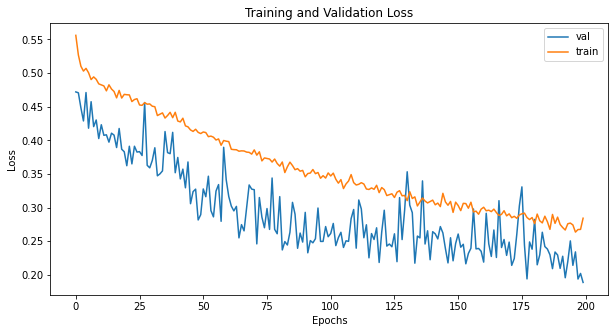

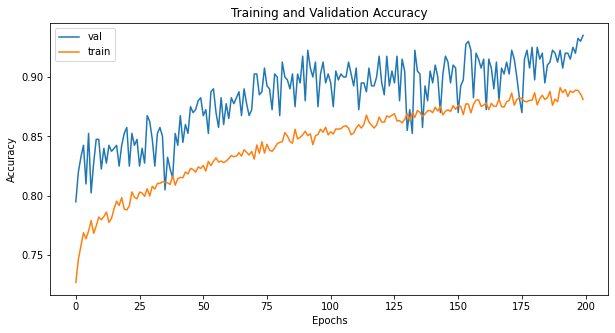

In [24]:
#Checking for overfitting/underfitting
val_loss_list = torch.from_numpy(np.asarray(torch.Tensor(val_loss_list).cpu()))
train_loss_list = torch.from_numpy(np.asarray(torch.Tensor(train_loss_list).cpu()))
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_loss_list,label="val")
plt.plot(train_loss_list,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

val_accuracy_list = torch.from_numpy(np.asarray(torch.Tensor(val_accuracy_list).cpu()))
train_accuracy_list = torch.from_numpy(np.asarray(torch.Tensor(train_accuracy_list).cpu()))
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accuracy_list,label="val")
plt.plot(train_accuracy_list,label="train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [25]:
actual_labels = []
predicted_labels = []

In [26]:
#Test accuracy
model.eval()
with torch.no_grad():
        test_accuracy = []
        
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)
            
            actual_labels.extend(np.asarray(label.cpu()).tolist())

            t_output = model(data)
            t_loss = criterion(t_output, label)
            
            predicted_labels.extend(np.asarray(t_output.argmax(dim=1).cpu()).tolist())

            acc = (t_output.argmax(dim=1) == label).float().mean()
            test_accuracy.append(acc)

        final_test_accuracy = sum(test_accuracy)/len(test_accuracy)
        print(f"test_acc : {final_test_accuracy:.4f}\n")

test_acc : 0.9157



In [27]:
print("Actual labels: ")
print(actual_labels)
print("Predicted labels: ")
print(predicted_labels)

Actual labels: 
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters in the model = {count_parameters(model)}")

Number of trainable parameters in the model = 79213918


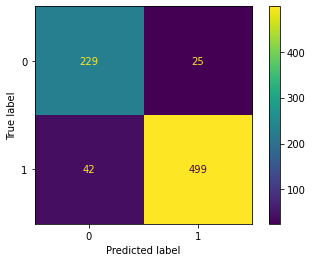

In [29]:
#Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

cnf_matrix = confusion_matrix(actual_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)

disp.plot()
plt.show()

In [30]:
#Specificity
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - cnf_matrix.sum(axis=0) - cnf_matrix.sum(axis=1) + np.diag(cnf_matrix)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

TNR = TN/(TN+FP)

print(f"Class wise specificity:")
print(f"Specificity = {TNR}\n")

print(f"Average specificity:")
print(f"Specificity = {np.average(np.array(TNR))}\n")

Class wise specificity:
Specificity = [0.92236599 0.9015748 ]

Average specificity:
Specificity = 0.9119703960295167



In [31]:
#Accuracy, Sensitivity, Precision, F1 score
from sklearn.metrics import classification_report

target_names = ['0', '1']
print(classification_report(actual_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       254
           1       0.95      0.92      0.94       541

    accuracy                           0.92       795
   macro avg       0.90      0.91      0.90       795
weighted avg       0.92      0.92      0.92       795



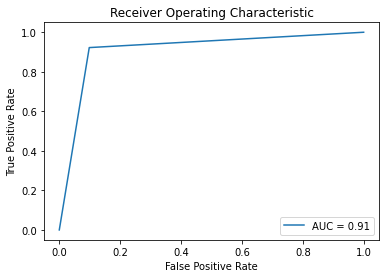

In [32]:
#ROC curve
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(actual_labels, predicted_labels)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [33]:
#AUC
print(f"AUC = {roc_auc}")

AUC = 0.9119703960295166
